# Sentiment Analytics on Cellular Service Provider Tweets

# Library Setup

Imports libraries for each tasks

In [ ]:
# Data preprocessing
import pandas as pd
import re
import string
import numpy as np

# Exploratory data analysis and visualization
import matplotlib.pyplot as plt
from matplotlib import colormaps
from wordcloud import WordCloud

# Indonesian language text processing
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine learning modelling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

# Data Cleansing

In this section, we will load the tweet data and clean it so that it can be analyzed.

Using pandas to read the CSV into a DataFrame

In [ ]:
# Read CSV
df = pd.read_csv('data/dataset_tweet_sentiment_cellular_service_provider.csv')
df.head()

,Id,Sentiment,Text Tweet
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDE..."
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>


Convert the sentiments to numerical values. Numerical labels is necessary because machine learning models work with numbers rather than text.

In [ ]:
# Replace Negative to 0 and Positive to 1
df['Sentiment'] = df['Sentiment'].map({'negative': 0, 'positive': 1})

Create a function to clean tweets by changing text to lowercase, removing tags, non ASCII characters, digits, punctuation, and extra spaces to ensure that model can focus on meaningful words.

In [4]:
def text_cleansing(text):

    # convert to lowercase
    text = text.lower()
    
    # remove tags
    text = text.replace('<provider_name>', '')
    text = text.replace('<url>', '')
    text = text.replace('<user_mention>', '')
    text = text.replace('<product_name>', '')
    
    # remove non ASCII words (emoticon, chinese word, etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    
    # remove digits
    text = re.sub(r'\d+', '', text)
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove whitespace in the beginning and end of sentence
    text = text.strip()
    
    # remove extra whitespace in the middle of sentence
    text = re.sub(r'\s+', ' ', text)
    
    return text

Applies the text_cleansing function to every tweet and stores the result in a new column

In [ ]:
# Apply to the text column
df['Text Clean'] = df['Text Tweet'].apply(text_cleansing)
df

,Id,Sentiment,Text Tweet,Text Clean
0,1,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,boikot gunakan produk bangsa sendiri
1,2,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...",saktinya balik lagi alhamdulillah v
2,3,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi bisa bantu kenapa di dalam kamar ...
3,4,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear akhir ini jaringan data lemot banget pada...
4,5,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam pendusta
...,...,...,...,...
295,296,1,"Pantesan lancar ya, sinyal <PROVIDER_NAME> yan...",pantesan lancar ya sinyal yang g lancar sekali...
296,297,1,Alhamdulillah lancar pakai <PROVIDER_NAME>,alhamdulillah lancar pakai
297,298,1,"Untung pakai internet <PROVIDER_NAME>, lancar,...",untung pakai internet lancar jadi dapat banyak...
298,299,1,"di tempat ramai seperti di lokasi wisata, <PRO...",di tempat ramai seperti di lokasi wisata tetap...


Set up an Indonesian stopword remover using Sastrawi to remove common words that dont add much meaning, but the application is commented out because removing stopwords lowered the model's performance.

In [ ]:
# Initialize the Sastrawi StopWord Remover
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

# Store a list of Indonesian stopwords
stopwords_list = stopword_factory.get_stop_words()

# Apply to the cleaned text column
# df['Text Clean'] = df['Text Clean'].apply(stopword_remover.remove)
# df.head()

Applies stemming using Sastrawi converting each word to its base form. It helps group variations of the same word into its base form, making the model learn patterns more effectively.

In [ ]:
# Initialize the Sastrawi stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# Apply to the cleaned text column
df['Text Clean'] = df['Text Clean'].apply(stemmer.stem)
df.head()

,Id,Sentiment,Text Tweet,Text Clean
0,1,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,boikot guna produk bangsa sendiri
1,2,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...",sakti balik lagi alhamdulillah v
2,3,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi bisa bantu kenapa di dalam kamar ...
3,4,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear akhir ini jaring data lot banget padahal h
4,5,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam dusta


# Exploratory Data Analysis

Counts how many samples belong to each sentiment class. We can see that there are more negative tweets but it is still fairly balanced.

In [8]:
df['Sentiment'].value_counts()

Sentiment
0    161
1    139
Name: count, dtype: int64

To see a quick overview of the proportion of negative and positive tweets, visualize the sentiment distribution using a pie chart.

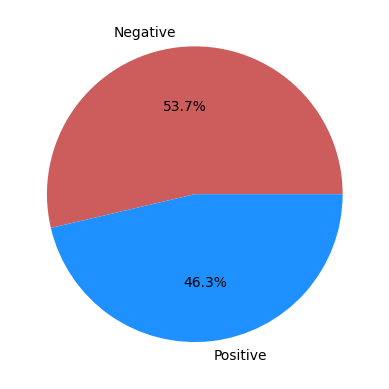

In [ ]:
# Create a pie chart
plt.pie(df['Sentiment'].value_counts(), labels=['Negative', 'Positive'], autopct='%1.1f%%', colors=['#CD5C5C', '#1E90FF'])
plt.show()

To see the distribution of the tweets, calculate the number of words in each cleaned tweet and then summarize using statistics. On average, each tweet has about 9 words, with most tweets ranging between 5 and 13 words. The shortest tweet has only 1 word, while the longest has 21 words.

In [ ]:
# Create a new column with word counts
df['Word Count'] = df['Text Clean'].str.split().apply(len)

# Show descriptive statistics of word counts
df['Word Count'].describe()

,Id,Sentiment,Text Tweet,Text Clean,Word Count
0,1,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,boikot guna produk bangsa sendiri,5
1,2,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...",sakti balik lagi alhamdulillah v,5
2,3,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi bisa bantu kenapa di dalam kamar ...,16
3,4,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear akhir ini jaring data lot banget padahal h,9
4,5,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam dusta,3
5,6,0,Untuk penembakan paket dari <PRODUCT_NAME> mas...,untuk tembak paket dari masih ganggu ya,7
6,7,1,"<PROVIDER_NAME> aku pakai <PROVIDER_NAME>, pa...",aku pakai paket nya udah off tapi ganti ada pa...,16
7,8,0,RT <USER_MENTION>: <PROVIDER_NAME> tak ada lag...,rt tak ada lagi dalam kamus perhapean saya boikot,9
8,9,0,keluhan gak ditanggapi. bikin emosi aja. pulsa...,keluh gak tanggap bikin emosi aja pulsa curi t...,18
9,10,0,#Bilboard iklan <PROVIDER_NAME> kok ada pesan ...,bilboard iklan kok ada pesan sembunyi boikot r...,8


To see specifically for each sentiments, separate the dataset into two dataframes.

In [ ]:
# Negative dataframe
negative_df = df[df['Sentiment'] == 0]

# Positive dataframe
positive_df = df[df['Sentiment'] == 1]

Create overlapping histograms of word counts for negative and positive tweets. We can see that both are similar, it suggests that tweet length is not a distinguishing factor for sentiment.

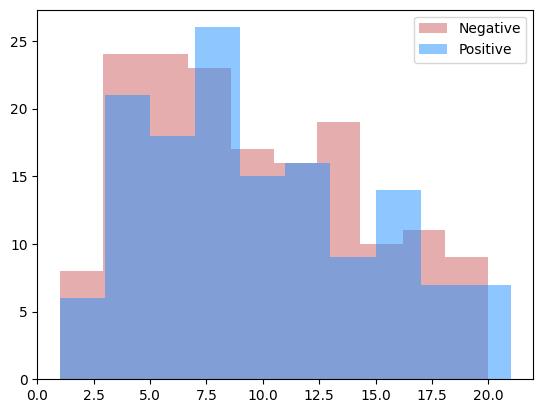

In [ ]:
# Create negative tweets word count histogram
plt.hist(negative_df['Word Count'], bins = 10, color='#CD5C5C', alpha=0.5, label='Negative')

# Create positive tweets word count histogram
plt.hist(positive_df['Word Count'], bins = 10, color='#1E90FF', alpha=0.5, label='Positive')

plt.legend(loc='upper right')
plt.show()

Generate a word cloud of the most frequent words found in positive tweets. Larger words appear more often in the dataset. Therefore, we can see the vocabulary that characterizes positive sentiment.

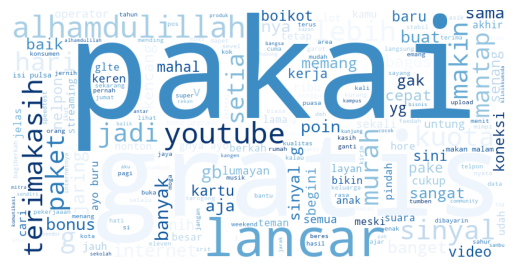

In [ ]:
# Create word cloud of positive tweet words
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_list, colormap='Blues').generate(' '.join(positive_df['Text Clean']))
plt.axis(False)
plt.imshow(wordcloud)

Generate a word cloud of the most frequent words found in negative tweets. Larger words appear more often in the dataset. Therefore, we can see the vocabulary that characterizes negative sentiment.

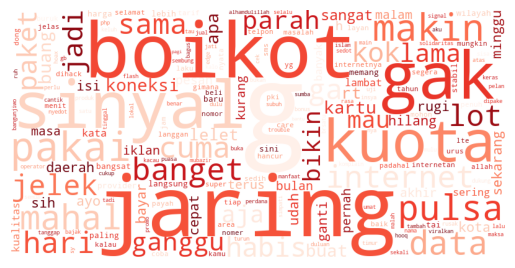

In [ ]:
# Create word cloud of negative tweet words
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_list, colormap='Reds').generate(' '.join(negative_df['Text Clean']))
plt.axis(False)
plt.imshow(wordcloud)

The word clouds gives a visual of frequent words, but its only approximate and doesnt show exact counts. CountVectorizer is needed to transform the text into numerical features so we can measure word frequencies in more detail.

In [ ]:
# Vectorize negative tweets using Bag of Words
negative_cv = CountVectorizer(stop_words=stopwords_list)
negative_word_freq = negative_cv.fit_transform(negative_df['Text Clean'])

# Create DataFrame of words and their frequencies from the negative tweets
negative_word_freq = pd.DataFrame({'Word':negative_cv.get_feature_names_out(),
                                   'Frequency':negative_word_freq.toarray().sum(axis=0)}).sort_values('Frequency')

negative_word_freq.tail(10)

,Word,Frequency
164,internet,12
351,pulsa,13
258,mahal,13
261,makin,15
318,pakai,18
231,kuota,19
396,sinyal,24
127,gak,24
62,boikot,25
180,jaring,31


This output shows customer dissatisfaction. For example:

- "jaring" (31) and "sinyal" (24) indicates frequent complaints about poor network and signals.
- "boikot" (25) indicates frustration or indicates a controversies of the provider.
- "mahal" (13) indicates frustration with expensive packages.

In [ ]:
# Vectorize positive tweets using Bag of Words
positive_cv = CountVectorizer(stop_words=stopwords_list)
positive_word_freq = positive_cv.fit_transform(positive_df['Text Clean'])

# Create DataFrame of words and their frequencies from the negative tweets
positive_word_freq = pd.DataFrame({'Word':positive_cv.get_feature_names_out(),
                                   'Frequency':positive_word_freq.toarray().sum(axis=0)}).sort_values('Frequency')

positive_word_freq.tail(10)

,Word,Frequency
155,jadi,9
426,terimakasih,10
209,kuota,10
223,lebih,11
461,youtube,12
10,alhamdulillah,13
396,sinyal,16
215,lancar,20
118,gratis,21
314,pakai,27


This output reflect customer satisfaction. For example:

- "lancar" (20) indicates users praising stable signal quality.
- "gratis" (21) indicates appreciation for free bonuses.
- "terimakasih" (10) and "alhamdulillah" (13) indicates expressions of gratitude.

In [ ]:
# Define a custom color function for matplotlib
def colormap(values, cmap):
    normalize = plt.Normalize(min(values), max(values))
    colors = [cmap(normalize(value)+0.5) for value in values]

    return colors

Visualize the top 10 most frequent words in positive and negative tweets, making the comparison clearer and more detailed.

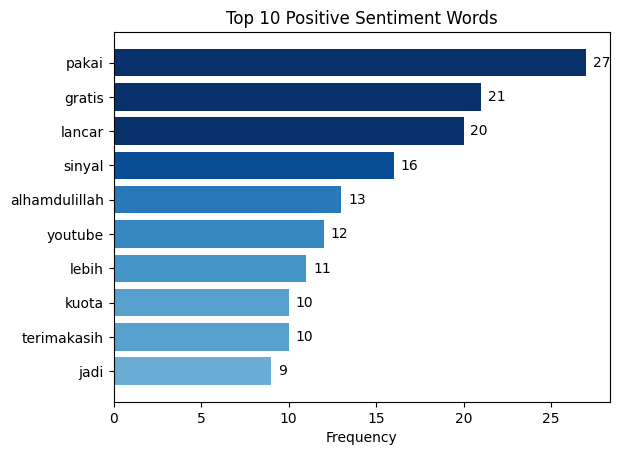

In [ ]:
# Creates a horizontal bar chart of the top 10 most frequent words in positive tweets
positive_barh = plt.barh(y=positive_word_freq['Word'].tail(10),
                         width=positive_word_freq['Frequency'].tail(10),
                         color=colormap(positive_word_freq['Frequency'].tail(10), colormaps['Blues']))
plt.title('Top 10 Positive Sentiment Words')
plt.bar_label(positive_barh, padding=5)
plt.xlabel('Frequency')
plt.show()

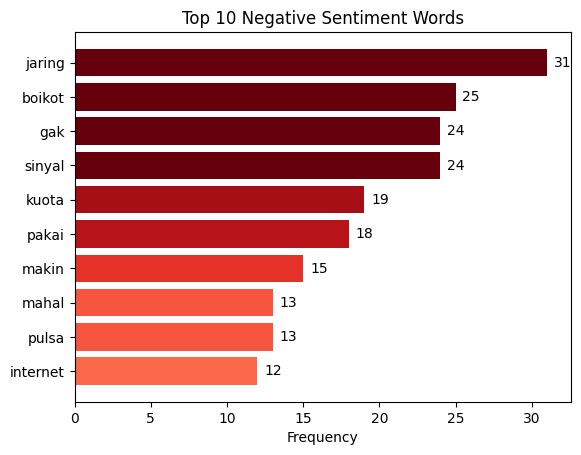

In [ ]:
# Creates a horizontal bar chart of the top 10 most frequent words in negative tweets
negative_barh = plt.barh(y=negative_word_freq['Word'].tail(10),
                         width=negative_word_freq['Frequency'].tail(10),
                         color=colormap(negative_word_freq['Frequency'].tail(10), colormaps['Reds']))
plt.title('Top 10 Negative Sentiment Words')
plt.bar_label(negative_barh, padding=5)
plt.xlabel('Frequency')
plt.show()
plt.show()

# Data Preprocessing

In this section, we will prepare the data that will be used for the machine learning modelling process.

Apply TF-IDF vectorization to cleaned tweets. TF-IDF counts the weights of each terms. The output is a sparse matrix where each column represents a weighted word feature of each tweets. This numerical representation is what the machine learning models will use for training.

In [ ]:
# Convert cleaned text into TF-IDF features
tfidf = TfidfVectorizer()
bow = tfidf.fit_transform(df['Text Clean'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2664 stored elements and shape (300, 847)>

Split the dataset into training and testing sets with 80:20 ratio. The training set is used to train the model, the testing set is used to evaluate performance.

In [ ]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(bow, 
                                                    df['Sentiment'], 
                                                    test_size=0.2,
                                                    random_state=1)

# Show the number of rows and columns for each
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(240, 847)
(60, 847)
(240,)
(60,)


# Machine Learning Modelling

In this section, we will be training a few classification models and then we will compare their performances.

## SVM

Create a Support Vector Classifier (SVC) model and trains it on the training data.

In [ ]:
# Initialize the model
model_svc = SVC()

# Fit the training set
model_svc.fit(x_train,y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Evaluate the SVC model on the test set. It predicts sentiment labels for unseen data and reports key performance metrics: accuracy, F1 score, and recall for each class (negative and positive).

In [ ]:
# Predict sentiment labels for the test set
y_pred_svc = model_svc.predict(x_test)

# Calculate model performance
print("Model SVC Accuracy Score: {}%".format(round(accuracy_score(y_test, y_pred_svc) * 100, 2)))
print("Model SVC F1 Score: {}%".format(round(f1_score(y_test, y_pred_svc) * 100, 2)))
print("Model SVC Positive Recall: {}%".format(round(recall_score(y_test, y_pred_svc, pos_label=0) * 100, 2)))
print("Model SVC Negative Recall: {}%".format(round(recall_score(y_test, y_pred_svc, pos_label=1) * 100, 2)))

Model SVC Accuracy Score: 83.33%
Model SVC F1 Score: 77.27%
Model SVC Positive Recall: 89.19%
Model SVC Negative Recall: 73.91%


Save the trained SVC model to disk using Joblib

In [ ]:
# Save the trained SVC model
joblib.dump(model_svc, 'models/model_svc.joblib')

['models/model_svc.joblib']

# Naive Bayes

Create a Naive Bayes (NB) model and trains it on the training data.

In [ ]:
# Initialize the Multinomial Naive Bayes model
model_nb = MultinomialNB()

# Fit the model using the training set
model_nb.fit(x_train,y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [ ]:
# Predict sentiment labels for the test set
y_pred_nb = model_nb.predict(x_test)

# Calculate model performance
print("Model NB Accuracy Score: {}%".format(round(accuracy_score(y_test, y_pred_nb) * 100, 2)))
print("Model NB F1 Score: {}%".format(round(f1_score(y_test, y_pred_nb) * 100, 2)))
print("Model NB Positive Recall: {}%".format(round(recall_score(y_test, y_pred_nb, pos_label=0) * 100, 2)))
print("Model NB Negative Recall: {}%".format(round(recall_score(y_test, y_pred_nb, pos_label=1) * 100, 2)))

Model NB Accuracy Score: 86.67%
Model NB F1 Score: 81.82%
Model NB Positive Recall: 91.89%
Model NB Negative Recall: 78.26%


Save the trained NB model to disk using Joblib

In [47]:
joblib.dump(model_nb, 'models/model_nb.joblib')

['models/model_nb.joblib']

# Random Forest

Create a Random Forest (RF) model and trains it on the training data.

In [31]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Predict sentiment labels for the test set
y_pred_rf = model_rf.predict(x_test)

# Calculate model performance
print("Model RF Accuracy Score: {}%".format(round(accuracy_score(y_test, y_pred_rf) * 100, 2)))
print("Model RF F1 Score: {}%".format(round(f1_score(y_test, y_pred_rf) * 100, 2)))
print("Model RF Positive Recall: {}%".format(round(recall_score(y_test, y_pred_rf, pos_label=0) * 100, 2)))
print("Model RF Negative Recall: {}%".format(round(recall_score(y_test, y_pred_rf, pos_label=1) * 100, 2)))

Model RF Accuracy Score: 81.67%
Model RF F1 Score: 75.56%
Model RF Positive Recall: 86.49%
Model RF Negative Recall: 73.91%


Save the trained RF model to disk using Joblib

In [48]:
joblib.dump(model_rf, 'models/model_rf.joblib')

['models/model_rf.joblib']

# LSTM

Unlike SVC or Naive Bayes, an LSTM model cannot use TF-IDF because it requires sequential word representations, so the LSTM model use tokenizations and embeddings that preserve the order of words. 

Split the dataframe directly into training and testing sets.

In [34]:
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(df['Text Clean'], 
                                                                df['Sentiment'],
                                                                test_size=0.2,
                                                                random_state=1)

print(x_train_df.shape)
print(x_test_df.shape)
print(y_train_df.shape)
print(y_test_df.shape)

(240,)
(60,)
(240,)
(60,)


To prepare the text data for the LSTM model, convert words into number sequences.

In [ ]:
num_words = 400

# Initialize the tokenizer with limited vocabulary and OOV token
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')

# Fit tokenizer on training text
tokenizer.fit_on_texts(x_train_df)

# Convert training and testing text into sequences
train_sequences = tokenizer.texts_to_sequences(x_train_df)
test_sequences = tokenizer.texts_to_sequences(x_test_df)

print("Before Tokenization: ", x_train_df.iloc[0])
print("After Tokenization : ", train_sequences[0])


Before Tokenization:  lumayan speedtest jaring glte area tarogong garut cukup muas
After Tokenization :  [148, 212, 6, 119, 97, 213, 214, 120, 149]


Since tweets vary in word count, use padding to make each sequence exactly 20 words (based on tweets word count). Shorter tweets are padded with zeros at the beginning, while longer ones are truncated.

In [ ]:
max_length = 20

# Pad training and testing sequences to fixed length
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

print("Before Padding: ", train_sequences[0])
print("After Padding : ", train_padded[0])

Before Padding:  [148, 212, 6, 119, 97, 213, 214, 120, 149]
After Padding :  [  0   0   0   0   0   0   0   0   0   0   0 148 212   6 119  97 213 214
 120 149]


Build and compile an LSTM model for classification. The model consists of:

- 1 Embedding layer with 128 dimensions. 
- 2 LSTM layers to learn sequential patterns. 
- 1 Dropout layer to reduce overfitting.
- 1 Dense layer with sigmoid activation as classification output. 

Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric.

In [ ]:
# Model Architecture
model_lstm = tf.keras.models.Sequential([

    # Embedding layer converts tokens into dense vector representations
    tf.keras.layers.Embedding(input_dim=num_words, output_dim=128),

    # First LSTM layer returns sequences to feed into the next LSTM
    tf.keras.layers.LSTM(units=128, return_sequences=True),

    # Second LSTM layer outputs the final sequence representation
    tf.keras.layers.LSTM(units=64, return_sequences=False),

    # Dropout layer for regularization
    tf.keras.layers.Dropout(rate=0.2),

    # Output layer with sigmoid activation for binary sentiment classification
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model with optimizer, loss, and metrics
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Add Early stopping to prevent overfitting by monitoring the validation accuracy and stopping training if it does not improve after 10 epochs.

In [ ]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10, # Number of epochs with no improvement before stopping
    restore_best_weights=True # Restore weights from the best epoch
)

Train the LSTM model using the padded sequences and sentiment labels. The training runs for 50 epochs but will stop earlier if the EarlyStopping callback detects no validation accuracy improvement.

In [ ]:
history = model_lstm.fit(
    x=train_padded, # Padded training data
    y=y_train_df, # Training labels data
    validation_data=(test_padded, y_test_df), # Padded and labels testing data
    epochs=50, # Number of Epochs
    callbacks=[early_stopping] # Early Stopping
)

Epoch 1/50


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.5208 - loss: 0.6936 - val_accuracy: 0.6167 - val_loss: 0.6797
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6333 - loss: 0.6832 - val_accuracy: 0.6500 - val_loss: 0.6814
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7875 - loss: 0.6539 - val_accuracy: 0.7833 - val_loss: 0.6291
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8208 - loss: 0.5241 - val_accuracy: 0.8167 - val_loss: 0.4890
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8125 - loss: 0.4025 - val_accuracy: 0.7667 - val_loss: 0.4403
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9375 - loss: 0.2559 - val_accuracy: 0.7333 - val_loss: 0.4267
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9375 - loss: 0.1552 - val_accuracy: 0.7833 - val_loss: 0.5140
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9708 - loss: 0.0873 - val_accuracy: 0.7833 - val_loss: 0.4968
Epoch 9/50


In [ ]:
# Convert test text into padded sequences
sequence = tokenizer.texts_to_sequences(x_test_df)
x_test_pred = pad_sequences(sequence, maxlen=max_length)

# Predict probabilities and round to 0 or 1
y_pred_lstm = model_lstm.predict(x_test_pred).round()

y_pred_lstm = model_lstm.predict(x_test_pred).round()
print("Model LSTM Accuracy Score: {}%".format(round(accuracy_score(y_test_df, y_pred_lstm) * 100, 2)))
print("Model LSTM F1 Score: {}%".format(round(f1_score(y_test_df, y_pred_lstm) * 100, 2)))
print("Model LSTM Positive Recall: {}%".format(round(recall_score(y_test, y_pred_lstm, pos_label=0) * 100, 2)))
print("Model LSTM Negative Recall: {}%".format(round(recall_score(y_test, y_pred_lstm, pos_label=1) * 100, 2)))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
Model LSTM Accuracy Score: 85.0%
Model LSTM F1 Score: 81.63%
Model LSTM Positive Recall: 83.78%
Model LSTM Negative Recall: 86.96%


Save the LSTM model to disk in the Keras format.

In [49]:
model_lstm.save('models/model_lstm.keras')

# Model Evaluation

This is a comparison table of all models (Naive Bayes, SVC, Random Forest, and LSTM) with 4 metrics: accuracy, F1 score, recall for negative class, and recall for positive class.

- **Accuracy**: Measures the overall percentage of tweets (positive and negative) correctly classified by the model.  
- **F1 Score**: Measures both precision and recall, to know how well the model on both correct positive and negative tweets.
- **Recall (Negative)**: Out of all actual negative tweets, how many were correctly identified as negative by the model.  
- **Recall (Positive)**: Out of all actual positive tweets, how many were correctly identified as positive by the model.  


In [65]:
pd.DataFrame(
    data = {'Naive Bayes': [accuracy_score(y_test, y_pred_nb), f1_score(y_test, y_pred_nb), recall_score(y_test, y_pred_nb, pos_label=0), recall_score(y_test, y_pred_nb, pos_label=1)],
            'Support Vector Classifier': [accuracy_score(y_test, y_pred_svc), f1_score(y_test, y_pred_svc), recall_score(y_test, y_pred_svc, pos_label=0), recall_score(y_test, y_pred_svc, pos_label=1)],
            'Random Forest' : [accuracy_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf), recall_score(y_test, y_pred_rf, pos_label=0), recall_score(y_test, y_pred_rf, pos_label=1)],
            'LSTM' : [accuracy_score(y_test, y_pred_lstm), f1_score(y_test, y_pred_lstm), recall_score(y_test, y_pred_lstm, pos_label=0), recall_score(y_test, y_pred_lstm, pos_label=1)]},
    index = ['Accuracy', 'F1 Score', 'Recall (Negative)', 'Recall (Positive)']).round(2)

,Naive Bayes,Support Vector Classifier,Random Forest,LSTM
Accuracy,0.87,0.83,0.82,0.85
F1 Score,0.82,0.77,0.76,0.82
Recall (Negative),0.92,0.89,0.86,0.84
Recall (Positive),0.78,0.74,0.74,0.87


In conclusion, for overall performance, LSTM is the best model because it handles both classes well (based on the Recall Score of both Positive and Negative sentiments). But, if the priority is catching negative tweets (for example, to detect customer complaints), then Naive Bayes is the better choice but with a lower performance of Positive tweets.